1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [8]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [9]:
import pandas as pd
import numpy as np
import datetime as dt


file_name = 'data/data_000637.txt'
max_line_index = len(open(file_name).readlines())-1
scale = 1   # change the scale factor to get differnt number of rows
N = max(10000,round(scale*max_line_index))
data = pd.read_csv(file_name, nrows=N)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [10]:

extimated_x = data['BX_COUNTER'].max()
print('Extimated BX per orbit: ',extimated_x)  #CONTROLLA QUESTO 

Extimated BX per orbit:  3563


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [11]:
def toNs(orb,x,tdc,extimated_x):
    return (orb*extimated_x+x)*25 + tdc*25/30

data['ABSOLUTE_TIME'] = toNs(data['ORBIT_CNT'], data['BX_COUNTER'], data['TDC_MEAS'], extimated_x)
display(data)

time_Ser = pd.to_datetime(data['ABSOLUTE_TIME'])
print(time_Ser)
 

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,3.446490e+14
1,1,0,124,3869200167,2374,27,3.446490e+14
2,1,0,63,3869200167,2553,28,3.446490e+14
3,1,0,64,3869200167,2558,19,3.446490e+14
4,1,0,64,3869200167,2760,25,3.446490e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,3.446500e+14
1310716,1,1,4,3869211171,763,11,3.446500e+14
1310717,1,0,64,3869211171,764,0,3.446500e+14
1310718,1,0,139,3869211171,769,0,3.446500e+14


0         1970-01-04 23:44:09.004934896
1         1970-01-04 23:44:09.004934897
2         1970-01-04 23:44:09.004939373
3         1970-01-04 23:44:09.004939490
4         1970-01-04 23:44:09.004944545
                       ...             
1310715   1970-01-04 23:44:09.985075886
1310716   1970-01-04 23:44:09.985075909
1310717   1970-01-04 23:44:09.985075925
1310718   1970-01-04 23:44:09.985076050
1310719   1970-01-04 23:44:09.985075890
Name: ABSOLUTE_TIME, Length: 1310720, dtype: datetime64[ns]


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [12]:


start2 = data['ABSOLUTE_TIME'].min()
stop2 = data['ABSOLUTE_TIME'].max()



print('Total duration HH:MM:SS ', dt.timedelta(seconds=(stop2-start2)*10**(-9)))

Total duration HH:MM:SS  0:00:00.980141


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [13]:
temp = data.groupby('TDC_CHANNEL').size().sort_values(ascending=False)
print('Noisy channels: ')
temp.iloc[[0,1,2]]

Noisy channels: 


TDC_CHANNEL
139    108059
64      66020
63      64642
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [14]:
count = len(data['ORBIT_CNT'].unique())
print('Number of non empty orbits: ',count)

Number of non empty orbits:  11001


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [15]:
count = len(data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique())
print('Number of unique orbits on channel 139: ',count)


Number of unique orbits on channel 139:  10976


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [16]:
data1 = data.copy()
data1 = data1[data1['FPGA']==0]
FPGA1 = pd.Series(data1.groupby('TDC_CHANNEL').size())
data2 = data.copy()
data2 = data2[data2['FPGA']==1]
FPGA2 = pd.Series(data2.groupby('TDC_CHANNEL').size())

print('FPGA 0')
print(FPGA1)
print('FPGA 1')
print(FPGA2)

FPGA 0
TDC_CHANNEL
1       1215
2       1602
3       1493
4       2352
5       1432
       ...  
129        2
130       33
137       32
138       34
139    75617
Length: 124, dtype: int64
FPGA 1
TDC_CHANNEL
1      28438
2      32669
3      21970
4      26403
5      15003
       ...  
129       35
130       38
137       36
138       36
139    32442
Length: 132, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

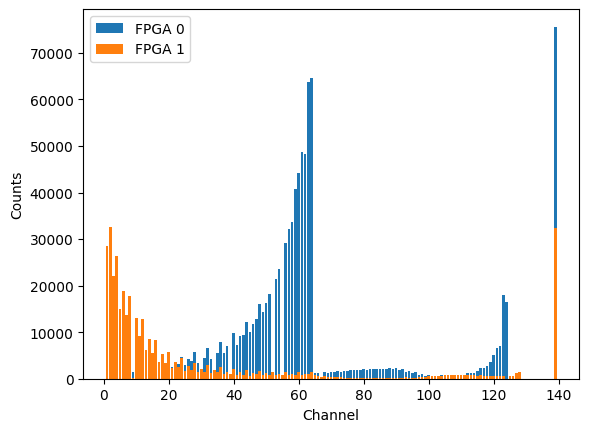

In [17]:
import matplotlib.pyplot as plt


plt.bar(FPGA1.index, FPGA1.values, label= 'FPGA 0')
plt.bar(FPGA2.index, FPGA2.values, label= 'FPGA 1')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.legend()
plt.show()